# Titanic Space
https://www.kaggle.com/competitions/spaceship-titanic/overview/description

## Data description
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, 
- FoodCourt, 
- ShoppingMall, 
- Spa, 
- VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Import necessary libraries<a class="anchor" id="imports"></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## Load source data<a class="anchor" id="load_data"></a>

In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
data.dtypes.value_counts()

object     7
float64    6
bool       1
Name: count, dtype: int64

In [6]:
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]])

In [8]:
X_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6519, 13), (2174, 13), (6519,), (2174,))

### Number of nulls

In [10]:
X_train.isnull().sum()

PassengerId       0
HomePlanet      158
CryoSleep       166
Cabin           152
Destination     131
Age             135
VIP             151
RoomService     134
FoodCourt       142
ShoppingMall    157
Spa             137
VRDeck          151
Name            148
dtype: int64

In [11]:
# Number of nulls
pd.DataFrame(X_train.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100).astype(float).round(1)

,missing_count,missing_pct
PassengerId,0.0,0.0
HomePlanet,158.0,2.4
CryoSleep,166.0,2.5
Cabin,152.0,2.3
Destination,131.0,2.0
Age,135.0,2.1
VIP,151.0,2.3
RoomService,134.0,2.1
FoodCourt,142.0,2.2
ShoppingMall,157.0,2.4


In [12]:
# how many percent of the data are missing?

pd.DataFrame(X_train.isnull().sum(), 
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100) \
    .sum()['missing_pct'].astype(float).round(1)

27.0

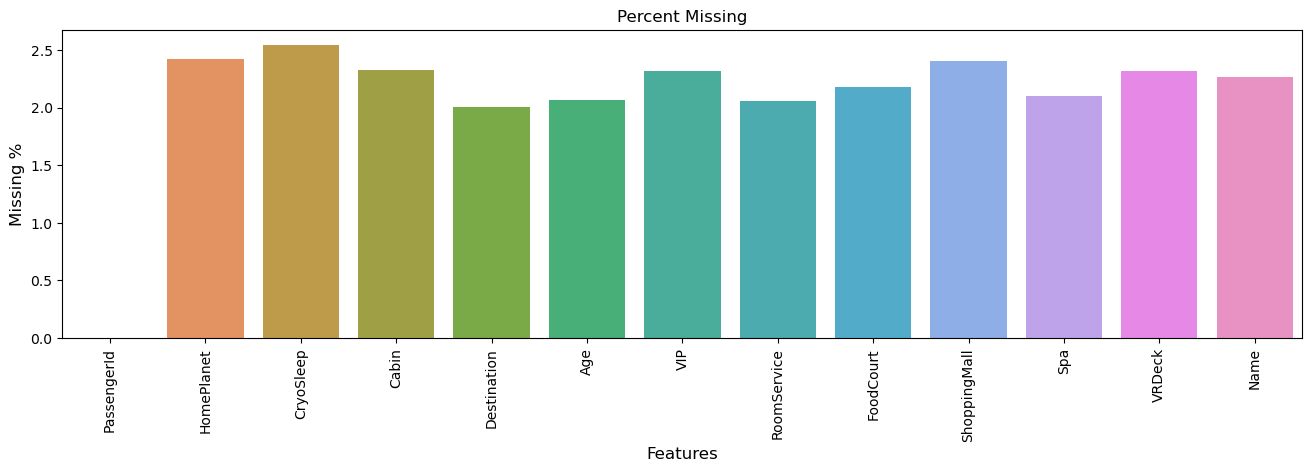

In [13]:
# Let's plot number of missing in each column

nan_train_X = ((X_train.isna().sum() / X_train.shape[0]*100)).reset_index()
nan_train_X.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(x=nan_train_X['feature'], y=nan_train_X['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing %', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

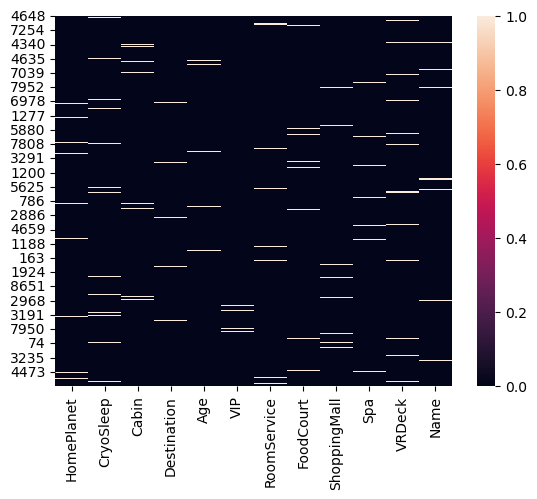

In [14]:
sns.heatmap(X_train[X_train.columns[1:]].isnull())
plt.show()

[]

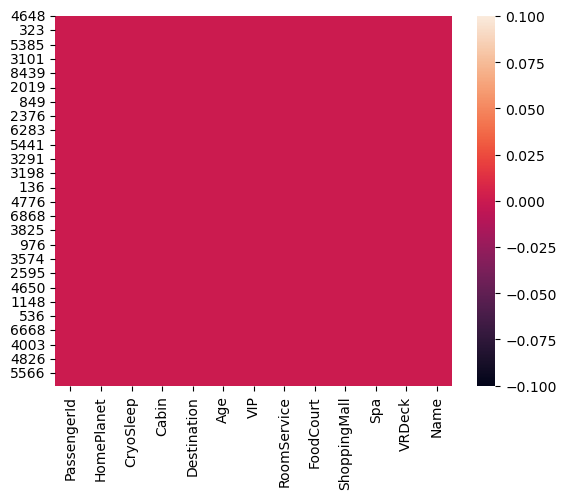

In [15]:
sns.heatmap(X_train.dropna().isnull())
plt.plot()

In [16]:
X_train.shape, X_train.dropna().shape

((6519, 13), (4940, 13))

## EDA<a class="anchor" id="eda"></a>

In [17]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
4648,4946_01,Earth,True,G/799/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Helley Kiddley
8412,8988_06,Earth,True,G/1448/S,TRAPPIST-1e,17.0,False,NaN,0.0,0.0,0.0,0.0,Caseye Fowlesterez
6514,6879_01,Earth,True,G/1119/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Joyces Englence
1357,1428_01,Earth,False,E/109/S,TRAPPIST-1e,44.0,False,0.0,200.0,128.0,460.0,0.0,Artis Hanghanson
5007,5350_01,Europa,False,C/170/P,TRAPPIST-1e,35.0,False,25.0,866.0,0.0,3198.0,459.0,Atinon Foraud


### PassangerID

In [18]:
#Find Group and No Pass
X_train[["G_Passenger", 'N_Passenger']] = X_train["PassengerId"].str.split('_', expand=True).astype('int')

#Set the Index
X_train.set_index('PassengerId',inplace=True)


X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,G_Passenger,N_Passenger
PassengerId,,,,,,,,,,,,,,
4946_01,Earth,True,G/799/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Helley Kiddley,4946,1
8988_06,Earth,True,G/1448/S,TRAPPIST-1e,17.0,False,NaN,0.0,0.0,0.0,0.0,Caseye Fowlesterez,8988,6
6879_01,Earth,True,G/1119/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Joyces Englence,6879,1
1428_01,Earth,False,E/109/S,TRAPPIST-1e,44.0,False,0.0,200.0,128.0,460.0,0.0,Artis Hanghanson,1428,1
5350_01,Europa,False,C/170/P,TRAPPIST-1e,35.0,False,25.0,866.0,0.0,3198.0,459.0,Atinon Foraud,5350,1


In [19]:
categorical_features = X_train.select_dtypes(include = ['object']).columns.to_list()
categorical_features

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

### Cabin

In [22]:
X_train['Cabin'].str.split("/",expand=True).isnull().sum()

0    152
1    152
2    152
dtype: int64

In [23]:
# Fill nan special values and split the field for three different fields

X_train['Cabin'] = X_train['Cabin'].fillna('X/9999/X')
X_test['Cabin'] = X_test['Cabin'].fillna('X/9999/X')

X_train['Cabin_1'] = X_train['Cabin'].str.split("/",expand=True).iloc[:,0]
X_train['Cabin_2'] = X_train.Cabin.str.split("/",expand=True).iloc[:,1]
X_train['Cabin_3'] = X_train.Cabin.str.split("/",expand=True).iloc[:,2]

X_test['Cabin_1'] = X_test.Cabin.str.split("/",expand=True).iloc[:,0]
X_test['Cabin_2'] = X_test.Cabin.str.split("/",expand=True).iloc[:,1]
X_test['Cabin_3'] = X_test.Cabin.str.split("/",expand=True).iloc[:,2]


In [24]:
X_train['Cabin'] = X_train['Cabin'].fillna('X/9999/X')
X_test['Cabin'] = X_test['Cabin'].fillna('X/9999/X')

for i, _ in enumerate(X_train['Cabin'].str.split("/",expand=True)):
    X_train['Cabin_' + str(i+1)] = X_train['Cabin'].str.split("/", expand=True)[i]
    X_test['Cabin_' + str(i+1)] = X_test['Cabin'].str.split("/", expand=True)[i]

In [25]:
X_train.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)

### Destination

In [26]:
X_train['Destination'].unique()

array(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22', nan], dtype=object)

In [27]:
X_train['Destination'] = X_train['Destination'].fillna('Unknown')
X_test['Destination'] = X_test['Destination'].fillna('Unknown')


### HomePlanet

In [29]:
imp = SimpleImputer(strategy="most_frequent")

X_train[['HomePlanet']] = imp.fit_transform(X_train[['HomePlanet']])
X_test[['HomePlanet']] = imp.transform(X_test[['HomePlanet']])

### CryoSleep

In [30]:
imp = SimpleImputer(strategy="most_frequent")

X_train[['CryoSleep']] = imp.fit_transform(X_train[['CryoSleep']])
X_test[['CryoSleep']] = imp.transform(X_test[['CryoSleep']])

### VIP

In [31]:
imp = SimpleImputer(strategy="most_frequent")

X_train[['VIP']] = imp.fit_transform(X_train[['VIP']])
X_test[['VIP']]=imp.transform(X_test[['VIP']])

### Age

In [32]:
imp = SimpleImputer(strategy="median")

X_train[['Age']]=imp.fit_transform(X_train[['Age']])
X_test[['Age']]=imp.transform(X_test[['Age']])

### RoomService

In [33]:
#Fill Na with 0
imp = SimpleImputer(strategy='constant', fill_value=0)

X_train[['RoomService']]=imp.fit_transform(X_train[['RoomService']])
X_test[['RoomService']]=imp.transform(X_test[['RoomService']])

### FoodCourt

In [34]:
imp = SimpleImputer(strategy='constant', fill_value=0)

X_train[['FoodCourt']] = imp.fit_transform(X_train[['FoodCourt']])
X_test[['FoodCourt']] = imp.transform(X_test[['FoodCourt']])

### ShoppingMall

In [35]:
imp = SimpleImputer(strategy='constant', fill_value=0)

X_train[['ShoppingMall']] = imp.fit_transform(X_train[['ShoppingMall']])
X_test[['ShoppingMall']] = imp.transform(X_test[['ShoppingMall']])

### Spa

In [36]:
imp = SimpleImputer(strategy='constant', fill_value=0)

X_train[['Spa']] = imp.fit_transform(X_train[['Spa']])
X_test[['Spa']] = imp.transform(X_test[['Spa']])

### VRDeck

In [37]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train[['VRDeck']] = imp.fit_transform(X_train[['VRDeck']])
X_test[['VRDeck']] = imp.transform(X_test[['VRDeck']])

### Name

In [38]:
X_train.drop('Name', axis=1, inplace=True)
X_test.drop('Name', axis=1, inplace=True)

### Result EDA

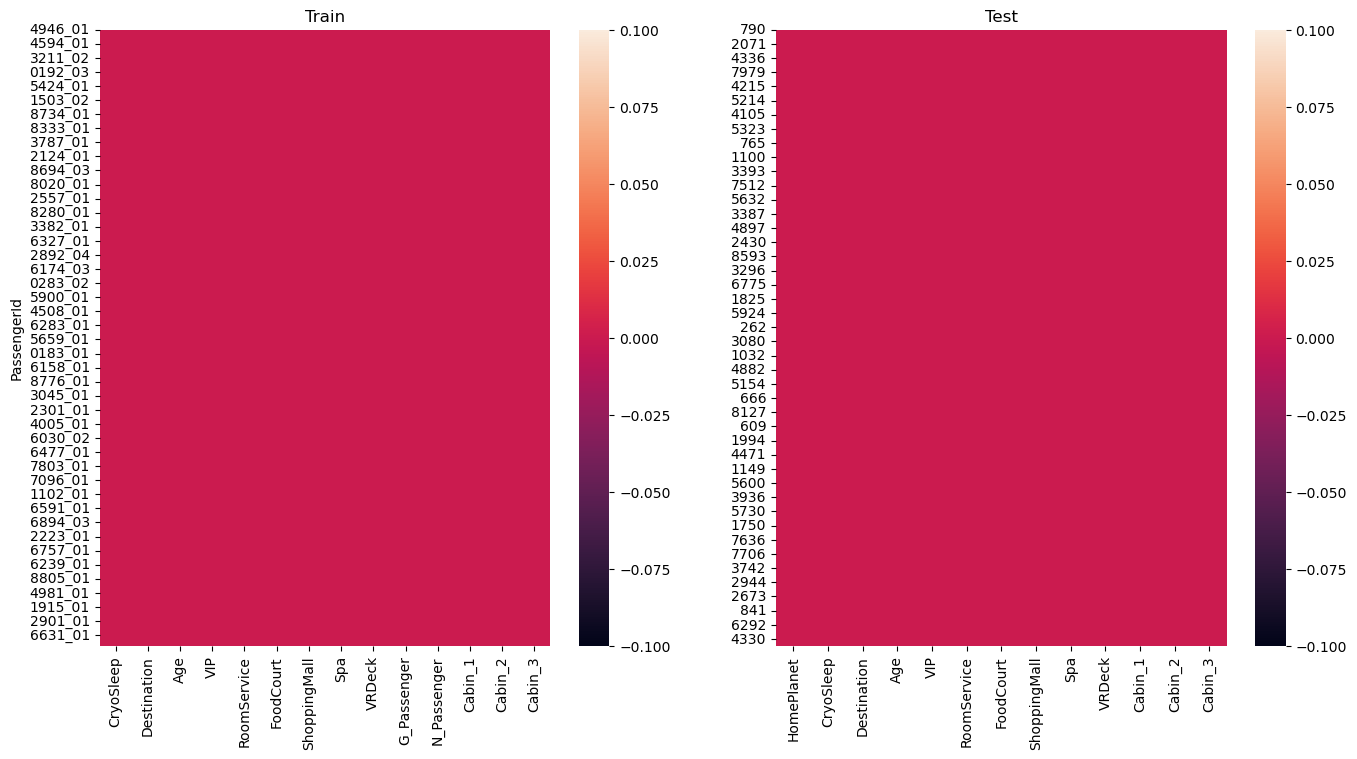

In [39]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.heatmap(X_train[X_train.columns[1:]].isnull())
ax.title.set_text('Train')

ax = fig.add_subplot(1, 2, 2)
ax = sns.heatmap(X_test[X_test.columns[1:]].isnull())
ax.title.set_text('Test')

plt.show()

## Почему представленное решение плохое?

## Pipeline

In [40]:
data = pd.read_csv("data/data.csv")

data[["G_Passenger", 'N_Passenger']] = data["PassengerId"].str.split('_', expand=True).astype('int')

data.set_index('PassengerId',inplace=True)
data.drop('Name', axis=1, inplace=True)



In [41]:
data.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'G_Passenger', 'N_Passenger'],
      dtype='object')

### Feature engineering

In [42]:
#Total Spend 
data['total_spent']= data['RoomService']+ data['FoodCourt']+ data['ShoppingMall']+ data['Spa']+ data['VRDeck']

In [43]:
#Age Group Pass
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 5, 12, 18, 50, 150], labels=['Baby','Child','Teen', 'Adult','Elderly'])


In [44]:
data['Cabin'] = data['Cabin'].fillna('X/9999/X')

for i, _ in enumerate(data['Cabin'].str.split("/",expand=True)):
    data['Cabin_' + str(i+1)] = data['Cabin'].str.split("/", expand=True)[i]

data.drop('Cabin', axis=1, inplace=True)

data['Cabin_2'] = data['Cabin_2'].astype(float)


In [45]:
data['CryoSleep'] = data['CryoSleep'].astype(bool)
data['VIP'] = data['VIP'].astype(bool)

In [46]:
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(include = ['object']).columns.to_list()

In [47]:
numerical_features

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'G_Passenger',
 'N_Passenger',
 'total_spent',
 'Cabin_2']

In [48]:
categorical_features

['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3']

### Разделим датасет

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Transported', axis=1), data['Transported'])

### Нормировка для численных признаков

In [50]:
scaler = StandardScaler()
ohe=OneHotEncoder(sparse_output=False)
data_train_scaled = scaler.fit_transform(X_train[numerical_features])
data_train_ohe = ohe.fit_transform(X_train[categorical_features])

## Почему предложенное решение плохое?

In [51]:
#   Для категориальных - применяем SimpleImputer, а затем StandardScaler
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all")),
])

#   Для категориальных - применяем SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features),
])

# Создание конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'G_Passenger',
                                                                    'N_Passenger',
                                                                    'total_spent',
                                                                    'Cabin_2']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['HomePlanet',
                                                                    'Destination',
                                                                    'Cabin_1',
                                                                    'Cabin_3'])]))])),
                ('classifier', LogisticRegression())])

In [52]:
target = ['Transported']
all_features = data.drop('Transported', axis=1).columns.tolist()

In [53]:
data_train, data_test = train_test_split(data[all_features + target], test_size=0.2, stratify=data[target])

## Model<a class="anchor" id="model"></a>

In [55]:
data_train[target].value_counts()

Transported
True           3502
False          3452
Name: count, dtype: int64

In [54]:
classifier_pipline.fit(data_train[all_features], data_train[target].iloc[:,0])

preds = classifier_pipline.predict(data_test[all_features])

print(accuracy_score(data_test[target], preds))

0.7837837837837838


/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Заменим классификатор

In [56]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", CatBoostClassifier(iterations=3000,
                         eval_metric='Accuracy',
                        verbose=0))])
classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'G_Passenger',
                                                                    'N_Passenger',
                                                                    'total_spent',
                                                                    'Cabin_2']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['HomePlanet',
                                                                    'Destination',
                                                                    'Cabin_1',
                                                                    'Cabin_3'])]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x30fb893c0>)])

In [57]:
classifier_pipline.fit(data_train[all_features], data_train[target].iloc[:,0])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)

print(accuracy_score(data_test[target], preds))

0.503737780333525


## Добавим ансамбли

In [59]:
clf1 = LogisticRegression(multi_class="multinomial", random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

blending_classifier = VotingClassifier(
    estimators=[("log_regrassion", clf1), 
                ("random_forest", clf2), 
                ("gnb", clf3)] 
)
blending_classifier

VotingClassifier(estimators=[('log_regrassion',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('random_forest',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())])

In [60]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", blending_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'G_Passenger',
                                                                    'N_Passenger',
                                                                    'total_spent',
                                                                    'Cabin_2']),
                                                                  ('categorical',
                                                                   Pip...
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['HomePlanet',
                                                                    'Destination',
                                                                    'Cabin_1',
                                                                    'Cabin_3'])]))])),
                ('classifier',
                 VotingClassifier(estimators=[('log_regrassion',
                                               LogisticRegression(multi_class='multinomial',
                                                                  random_state=1)),
                                              ('random_forest',
                                               RandomForestClassifier(n_estimators=50,
                                                                      random_state=1)),
                                              ('gnb', GaussianNB())]))])

In [61]:
classifier_pipline.fit(data_train[all_features], data_train[target].iloc[:,0])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)

print(accuracy_score(data_test[target], preds))

/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7924094307073031


### А если хотим добавить стекинг

In [64]:
estimators = [
    ("Random_Forest", RandomForestClassifier()),
    ("Xgboost", XGBClassifier()),
    ("SVM", LinearSVC()),
    
]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=False),
    n_jobs=-1,
    verbose=False,
)

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", stacking_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'G_Passenger',
                                                                    'N_Passenger',
                                                                    'total_spent',
                                                                    'Cabin_2']),
                                                                  ('categorical',
                                                                   Pip...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...)),
                                                ('SVM', LinearSVC())],
                                    final_estimator=LogisticRegression(n_jobs=-1,
                                                                       verbose=False),
                                    n_jobs=-1, verbose=False))])

In [65]:
classifier_pipline.fit(data_train[all_features], data_train[target].iloc[:,0])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)

print(accuracy_score(data_test[target], preds))

/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stureiko/miniforge3/envs

0.7952846463484762


In [ ]:
# TODO: 1. Add correlation matrix for variables and drop var with high correlation
#       2. Add cross validation and hyper parameter tuning for ansabless
